In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

#     lc = learning_curve(estimator, 
#                         x_train, 
#                         y_train, 
#                         cv=cv, 
#                         scoring=scoring)
#     samples, train, test = lc[0],lc[1],lc[2]
#     plt.plot(samples, np.mean(train, axis=1))
#     plt.plot(samples, np.mean(test, axis=1))
    return np.mean(train_scores), np.mean(test_scores)

In [18]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [19]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [20]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_catboost.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_xgb.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_v2.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_lightgbm', 'probs_catboost','probs_xgb', 'probs_gbc', 'probs_lightgbm_v2']

In [21]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_catboost.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_xgb.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_v2.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns  = ['probs_lightgbm', 'probs_catboost', 'probs_xgb', 'probs_gbc', 'probs_lightgbm_v2']

In [22]:
train.corr()

,probs_lightgbm,probs_catboost,probs_xgb,probs_gbc,probs_lightgbm_v2
probs_lightgbm,1.000000,0.981173,0.975493,0.950469,0.983192
probs_catboost,0.981173,1.000000,0.974264,0.955481,0.976212
probs_xgb,0.975493,0.974264,1.000000,0.948469,0.969609
probs_gbc,0.950469,0.955481,0.948469,1.000000,0.948731
probs_lightgbm_v2,0.983192,0.976212,0.969609,0.948731,1.000000


In [24]:
test.corr()

,probs_lightgbm,probs_catboost,probs_xgb,probs_gbc,probs_lightgbm_v2
probs_lightgbm,1.000000,0.990727,0.991912,0.972520,0.992269
probs_catboost,0.990727,1.000000,0.991327,0.975976,0.987053
probs_xgb,0.991912,0.991327,1.000000,0.976279,0.987711
probs_gbc,0.972520,0.975976,0.976279,1.000000,0.971856
probs_lightgbm_v2,0.992269,0.987053,0.987711,0.971856,1.000000


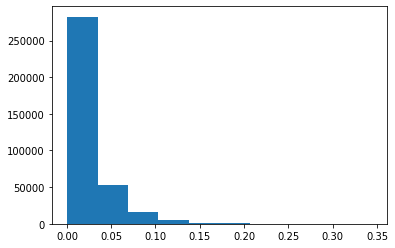

In [25]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

In [26]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
def get_roc_auc_estimado(train, y_train, columns):
    train = train[columns]
    Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
    # https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
    solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
    param_grid = {'C': Cs,'solver':solvers}
    ### encontrando los hiper_parámetros
    fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
    ### instanciar el estimador
    estimator = fitting.best_estimator_
#     print(estimator)
    ### aplicar cross_validate y learning_rate 
    train_scores, test_scores = cross_validate_learning_rate(estimator, train, y_train, scoring='roc_auc')
    return estimator, train_scores, test_scores

In [12]:
# from itertools import combinations  
# comb_5 = combinations(['probs_lightgbm', 'probs_catboost', 'probs_lightgbm_v2', 'probs_xgb','probs_gbc'], 2) 
# comb_4 = combinations(['probs_lightgbm', 'probs_catboost', 'probs_lightgbm_v2', 'probs_xgb','probs_gbc'], 3) 
# comb_3 = combinations(['probs_lightgbm', 'probs_catboost', 'probs_lightgbm_v2', 'probs_xgb','probs_gbc'], 4) 
# comb_2 = combinations(['probs_lightgbm', 'probs_catboost', 'probs_lightgbm_v2', 'probs_xgb','probs_gbc'], 5)
# # Print the obtained combinations 
# list_of_combinations = []
# for i in list(comb_2): 
#     list_of_combinations.append(list(i))
# for i in list(comb_3): 
#     list_of_combinations.append(list(i))
# for i in list(comb_4): 
#     list_of_combinations.append(list(i))
# for i in list(comb_5): 
#     list_of_combinations.append(list(i))

In [12]:
# best_score = 0
# best_estimator = 0
# for c in list_of_combinations:
#     print('#####################################')
#     print('Analizando ', ', '.join(c))
#     estimator, train_score, test_score = get_roc_auc_estimado(train, y_train, c)
#     if test_score > best_score:
#         best_score = test_score
#         best_estimator = estimator
#         print(f" {','.join(c)}, tienen un train_score de {round(train_score,5)} y test_score de {round(test_score,5)}")

Analizando  probs_lightgbm, probs_catboost, probs_lightgbm_v2, probs_xgb, probs_gbc
train_scores: 0.8552870042338394
test_scores: 0.8552341208838141
 probs_lightgbm, probs_catboost, probs_lightgbm_v2, probs_xgb, probs_gbc, tienen un train_score de 0.85529 y test_score de 0.85523
Analizando  probs_lightgbm, probs_catboost, probs_lightgbm_v2, probs_xgb
train_scores: 0.8552244339953387
test_scores: 0.8551692835222677
Analizando  probs_lightgbm, probs_catboost, probs_lightgbm_v2, probs_gbc
train_scores: 0.8552205678027164
test_scores: 0.8551772676340477
Analizando  probs_lightgbm, probs_catboost, probs_xgb, probs_gbc
train_scores: 0.8548817014288936
test_scores: 0.8548506572117478
Analizando  probs_lightgbm, probs_lightgbm_v2, probs_xgb, probs_gbc
train_scores: 0.8549247917576916
test_scores: 0.8548869552006323
Analizando  probs_catboost, probs_lightgbm_v2, probs_xgb, probs_gbc
train_scores: 0.8543257337655719
test_scores: 0.8542836881239253
Analizando  probs_lightgbm, probs_catboost, prob

In [34]:
keep_columns = ['probs_lightgbm', 'probs_lightgbm_v2','probs_catboost', 'probs_gbc']
estimator, train_score, test_score = get_roc_auc_estimado(train, y_train, keep_columns)

train_scores: 0.8552205678027164
test_scores: 0.8551772676340477


In [35]:
estimator.coef_

array([[ 3.03739209,  1.71817256,  2.25519488, -0.39402787]])

In [36]:
test_stacking = pd.Series(estimator.predict_proba(test[keep_columns])[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.045024
1         0.067199
2         0.052986
3         0.587453
4         0.127642
            ...   
396661    0.065888
396662    0.149657
396663    0.186598
396664    0.057022
396665    0.056621
Name: target, Length: 396666, dtype: float64

In [37]:
test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_GBC_0.85517.csv")  ### score de 0.85601 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM_CB_GBC_0.85473.csv")  ### score de 0.85557 en la tabla publica
# test_stacking.to_csv("../results/stacking_5models_LGBM2_CB_XGB_GBC_0.85523.csv")  ### score de 0.85448 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_CB_0.85512.csv")  ### score de 0.85592 en la tabla publica

In [23]:
# test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_XGB_0.85464.csv")  ### score de 0.85596 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM_CB_0.85419.csv")  ### score de 0.85567 en la tabla publica

In [16]:
# test_stacking.to_csv("../results/stacking_3models_LGBM2_GBC_0.84805.csv")  ### score de 0.84996 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_R_0.84729.csv")  ### score de 0.84927 en la tabla publica
# test_stacking.to_csv("../results/stacking_6models_0.84767.csv")  ### score de 0.84910 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RNN_0.84830.csv")  ### score de 0.84974 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RF_0.84694.csv")  ### score de 0.84874  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_XGB_0.84807.csv")  ### score de 0.84977  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_0.84811.csv")  ### score de 0.84970  en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM2_0.84801.csv")  ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84834.csv")  ### score de 0.84991 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84833.csv") ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_CB_LGBM_0.84721.csv") ### score de 0.84882 en la tabla publica

In [17]:
### Por lo que se puede concluir que los dos modelos de lightGBM (el normal, y el que toma en cuenta las categoricas).
### Tienen mejor performance